In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
from utils.analysis import Tree
from utils.fileUtils.sr import NMSSM_MX_700_MY_400, QCD_B_List, TTJets
from utils.fileUtils.sr import NMSSM_List
from utils.fileUtils import *
from utils.xsecUtils import *
from utils.plotter import Hist, easy_bins, makeTitle
from utils.useCMSstyle import *
from utils.cutConfig import jet_btagWP

tight_b = jet_btagWP[1]
medium_b = jet_btagWP[2]
loose_b = jet_btagWP[3]

In [4]:
import awkward as ak
import numpy as np
import uproot

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as lines
import matplotlib.patches as patches

In [6]:
def x_bins(bins):
    return (bins[:-1] + bins[1:])/2

In [7]:
pt_bins = easy_bins['pt']
score_bins = easy_bins['score']
mH_bins = easy_bins['mH']
x = x_bins(score_bins)

In [8]:
# signal_tree = Tree(NMSSM_MX_700_MY_400)
bkgd_tree = Tree(QCD_B_List + [TTJets])

In [28]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}$\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

cf_labels=['Total','Trigger',r'$p_T>20$ GeV'+'\n6 jets', r'$|\eta|<2.5$'+'\n6 jets', 'Pass JetID\n6 jets', 'Pass PileupID\n6 jets', r'$p_T>60$ GeV'+'\n& Tight b-tag', r'$p_T>40$ GeV'+'\n& Tight b-tag', r'$p_T>40$ GeV'+'\n& Medium b-tag', r'$p_T>20$ GeV'+'\n& Medium b-tag', r'$p_T>20$ GeV'+'\n& Loose b-tag', r'$p_T>20$ GeV'+'\n& Loose b-tag']

cf_labels = cf_labels[::-1]

In [9]:
# PRESELECTIONS
pt_min = 20
eta_max = 2.5
jetID = 1
PUID = 1

def checkBit(id, cut):
    return id & (1 << cut)

In [10]:
n = 9
edges = np.linspace(0,1,n)
x = (edges[1:] + edges[:-1])/2
width = x[1]-x[0]

In [26]:
# cutflows_sig_jets = []
cutflows = []

year = 2018
for sample in NMSSM_List:
    mass_point = sample.split("/")[-2] # extract mass point for saving plots

    # open file
    f = uproot.open(sample)

    # extract info necessary for MC scale factor
    samp, xsec = next( ((key,value) for key,value in xsecMap.items() if key in sample),("unk",1) )
    lumi = lumiMap[year][0]
    total = f['h_cutflow'].to_numpy()[0][0]
    scale = lumi*xsec/total
    
    # create cutflow object
    cf = f['h_cutflow'].to_numpy()[0] * scale
    
    # open tree
    t = f['sixBtree']
    # signal_jets = t['jet_signalId'].array() > -1
    signal_jets = ak.local_index(t['jet_signalId'].array())
    
    # preselections
    pt_mask = t['jet_pt'].array()[signal_jets] > pt_min # pt selection
    eta_mask = abs(t['jet_eta'].array())[signal_jets] < eta_max # eta selection
    jetID_mask = checkBit(t['jet_id'].array(), jetID)[signal_jets] > 0 # JetID selection
    PUID_mask = checkBit(t['jet_puid'].array(), PUID)[signal_jets] > 0 # PUID selection

    jet_pt = t['jet_pt'].array()
    jet_btag = t['jet_btag'].array()
    padded_pt   = ak.pad_none(jet_pt[signal_jets],4,axis=1)
    padded_btag = ak.pad_none(jet_btag[signal_jets],4,axis=1)

    # six b selections
    tight_60  = (jet_pt > 60)[:,0] & (jet_btag > tight_b)[:,0] # first jet
    tight_40  = (jet_pt > 40)[:,1] & (jet_btag > tight_b)[:,1] # second jet
    medium_40 = (jet_pt > 40)[:,2] & (jet_btag > medium_b)[:,2] # third jet
    medium_20 = (jet_pt > 20)[:,3] & (jet_btag > medium_b)[:,3] # fourth jet
    loose_20_5 = (jet_pt > 20)[:,3] & (jet_btag > loose_b)[:,3] # fifth jet
    loose_20_6 = (jet_pt > 20)[:,4] & (jet_btag > loose_b)[:,4] # sixth jet

    # calculate cut flow amounts and append to cf
    pt_count = ak.sum(ak.sum(pt_mask, axis=1) > 5) * scale
    eta_count = ak.sum(ak.sum(pt_mask & eta_mask, axis=1) > 5) * scale
    jetID_count = ak.sum(ak.sum(pt_mask & eta_mask & jetID_mask, axis=1) > 5) * scale
    PUID_count = ak.sum(ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) * scale
    sel1_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60) * scale
    sel2_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40) * scale
    sel3_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40) * scale
    sel4_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20) * scale
    sel5_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20 & loose_20_5) * scale
    sel6_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20 & loose_20_5 & loose_20_6) * scale

    cf = np.append(cf, pt_count)
    cf = np.append(cf, eta_count)
    cf = np.append(cf, jetID_count)
    cf = np.append(cf, PUID_count)
    cf = np.append(cf, sel1_count)
    cf = np.append(cf, sel2_count)
    cf = np.append(cf, sel3_count)
    cf = np.append(cf, sel4_count)
    cf = np.append(cf, sel5_count)
    cf = np.append(cf, sel6_count)

    cutflows.append(cf)

    ncuts = len(cf)

In [68]:
sorted_2j_scores = ak.sort(t['dijet_2j_score'].array(), axis=1)[:,::-1]
sorted_id1 = t['dijet_id1'].array()[ak.argsort(t['dijet_2j_score'].array(), axis=1)[:,::-1]]
sorted_id2 = t['dijet_id2'].array()[ak.argsort(t['dijet_2j_score'].array(), axis=1)[:,::-1]]

In [89]:
sorted_2j_scores[0]

<Array [0.999, 0.998, ... 2.61e-07, 5.18e-09] type='55 * float32'>

In [120]:
first_score = ak.firsts(sorted_2j_scores).to_numpy()

In [109]:
first_choice = (sorted_id1 != ak.firsts(sorted_id1)) & (sorted_id2 != ak.firsts(sorted_id2))
scores_after_first_choice = sorted_2j_scores[first_choice]
id1_after_first_choice = sorted_id1[first_choice]
id2_after_first_choice = sorted_id2[first_choice]

In [121]:
second_score = ak.firsts(scores_after_first_choice).to_numpy()

In [110]:
second_choice = (id1_after_first_choice != ak.firsts(id1_after_first_choice)) & (id2_after_first_choice != ak.firsts(id2_after_first_choice))
scores_after_second_choice = scores_after_first_choice[second_choice]
id1_after_second_choice = id1_after_first_choice[second_choice]
id2_after_second_choice = id2_after_first_choice[second_choice]


In [122]:
third_score = ak.firsts(scores_after_second_choice).to_numpy()

In [124]:
score_3d = np.sqrt((first_score**2 + second_score**2 + third_score**2)/3)

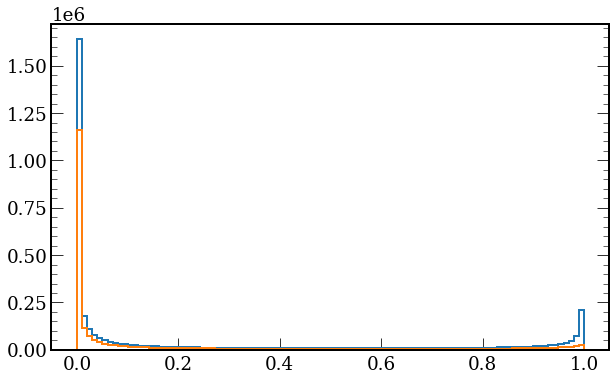

In [131]:

fig, ax, n, b = Hist(ak.flatten(sorted_2j_scores), scale=1, bins=score_bins)
# fig, ax, n, b = Hist(ak.flatten(scores_after_first_choice), scale=1, bins=score_bins, fig=fig, ax=ax, density=1)
fig, ax, n, b = Hist(ak.flatten(scores_after_second_choice), scale=1, bins=score_bins, fig=fig, ax=ax)
# fig, ax, n, b = Hist(score_3d, scale=1, bins=score_bins, fig=fig, ax=ax, density=1)

In [72]:
ak.firsts(sorted_id2)

<Array [3, 1, 1, 3, 3, 3, ... 4, 3, 4, 9, 4, 2] type='68663 * ?float32'>

In [47]:
cutflows_sig_jets = []
# cutflows = []

year = 2018
for sample in NMSSM_List:
    mass_point = sample.split("/")[-2] # extract mass point for saving plots

    # open file
    f = uproot.open(sample)

    # extract info necessary for MC scale factor
    samp, xsec = next( ((key,value) for key,value in xsecMap.items() if key in sample),("unk",1) )
    lumi = lumiMap[year][0]
    total = f['h_cutflow'].to_numpy()[0][0]
    scale = lumi*xsec/total
    
    # create cutflow object
    cf = f['h_cutflow'].to_numpy()[0] * scale
    
    # open tree
    t = f['sixBtree']
    signal_jets = t['jet_signalId'].array() > -1
    # signal_jets = ak.local_index(t['jet_signalId'].array())
    
    # preselections
    pt_mask = t['jet_pt'].array()[signal_jets] > pt_min # pt selection
    eta_mask = abs(t['jet_eta'].array())[signal_jets] < eta_max # eta selection
    jetID_mask = checkBit(t['jet_id'].array(), jetID)[signal_jets] > 0 # JetID selection
    PUID_mask = checkBit(t['jet_puid'].array(), PUID)[signal_jets] > 0 # PUID selection

    jet_pt = t['jet_pt'].array()
    jet_btag = t['jet_btag'].array()
    padded_pt   = ak.pad_none(jet_pt[signal_jets],6,axis=1)
    padded_btag = ak.pad_none(jet_btag[signal_jets],6,axis=1)

    # six b selections
    tight_60  = (padded_pt > 60)[:,0] & (padded_btag > tight_b)[:,0] # first jet
    tight_40  = (padded_pt > 40)[:,1] & (padded_btag > tight_b)[:,1] # second jet
    medium_40 = (padded_pt > 40)[:,2] & (padded_btag > medium_b)[:,2] # third jet
    medium_20 = (padded_pt > 20)[:,3] & (padded_btag > medium_b)[:,3] # fourth jet
    loose_20_5 = (padded_pt > 20)[:,3] & (padded_btag > loose_b)[:,3] # fifth jet
    loose_20_6 = (padded_pt > 20)[:,4] & (padded_btag > loose_b)[:,4] # sixth jet

    # calculate cut flow amounts and append to cf
    pt_count = ak.sum(ak.sum(pt_mask, axis=1) > 5) * scale
    eta_count = ak.sum(ak.sum(pt_mask & eta_mask, axis=1) > 5) * scale
    jetID_count = ak.sum(ak.sum(pt_mask & eta_mask & jetID_mask, axis=1) > 5) * scale
    PUID_count = ak.sum(ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) * scale
    sel1_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60) * scale
    sel2_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40) * scale
    sel3_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40) * scale
    sel4_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20) * scale

    sel5_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20 & loose_20_5) * scale
    sel6_count = ak.sum((ak.sum(pt_mask & eta_mask & jetID_mask & PUID_mask, axis=1) > 5) & tight_60 & tight_40 & medium_40 & medium_20 & loose_20_5 & loose_20_6) * scale

    cf = np.append(cf, pt_count)
    cf = np.append(cf, eta_count)
    cf = np.append(cf, jetID_count)
    cf = np.append(cf, PUID_count)
    cf = np.append(cf, sel1_count)
    cf = np.append(cf, sel2_count)
    cf = np.append(cf, sel3_count)
    cf = np.append(cf, sel4_count)
    cf = np.append(cf, sel5_count)
    cf = np.append(cf, sel6_count)

    cutflows_sig_jets.append(cf)

    ncuts = len(cf)

In [48]:
repeated_cutflows = np.repeat(np.asarray(cutflows_sig_jets), 3, axis=0)

In [49]:
repeated_cutflows[1::3] = np.asarray((repeated_cutflows[1::3] / repeated_cutflows[0::3][0][0] * 100),int)

In [50]:
for i,cutflow in enumerate(repeated_cutflows[2::3].copy()):
    for j,n in enumerate(cutflow[1:]):
        repeated_cutflows[2::3][i][j+1] = int(n/cutflow[j]*100)
    repeated_cutflows[2::3][i][0] = 100

In [51]:
repeated_cutflows[0::3] = np.asarray(repeated_cutflows[0::3], dtype=int)

In [52]:
repeated_cutflows = repeated_cutflows.T

In [44]:
import pandas as pd

In [53]:
df = pd.DataFrame(repeated_cutflows, index=cf_labels[::-1])

In [54]:
df.to_latex('cutflow_sig_jets.tex')

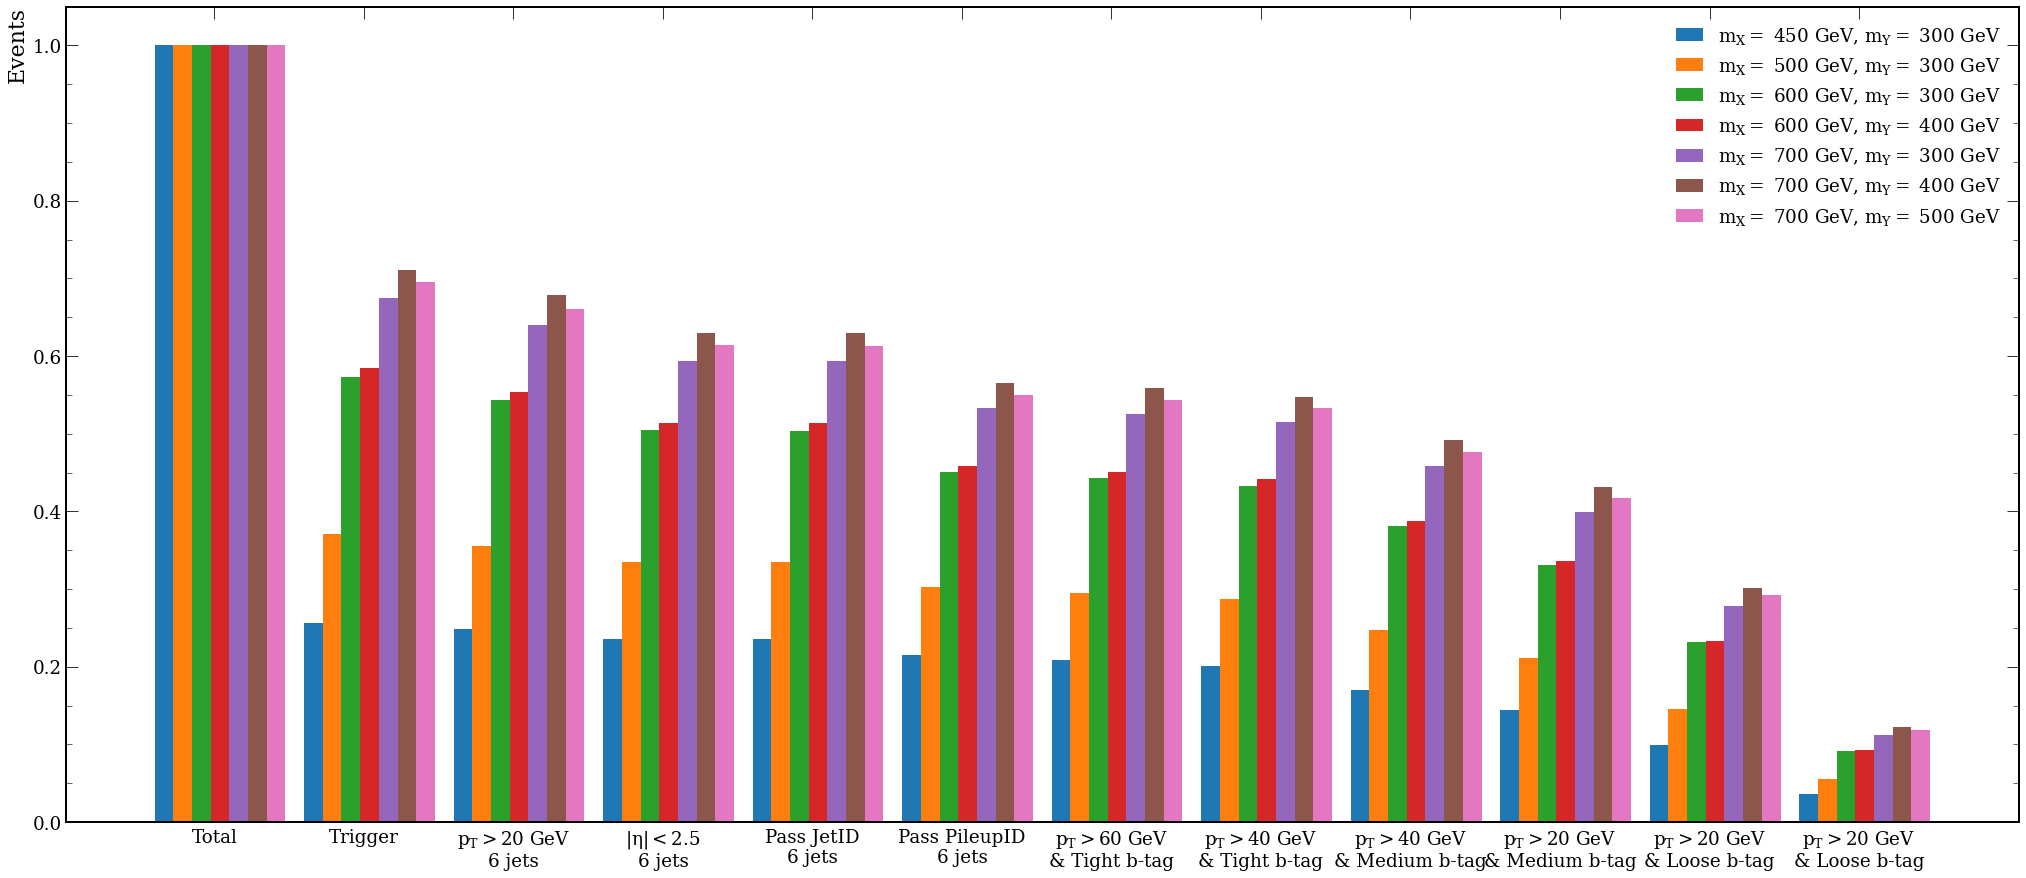

In [29]:
# make figure and axis objects
# fig, axs = plt.subplots(figsize=(25,10), nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,1]}, sharey=True)
fig, ax = plt.subplots(figsize=(35,15))
offsets = x

year = 2018
for sample,offset,cutflow in zip(NMSSM_List,offsets,cutflows):
    mass_point = sample.split("/")[-2] # extract mass point for saving plots
    cf = cutflow
    total = cutflow[0]
    bar = ax.bar(x=np.arange(offset,ncuts+offset), height=cf/total, width=width, align='center', label=makeTitle(sample))
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=True)
    ax.set_xticks(np.arange(0,ncuts)+0.4)
    ax.set_xticklabels(cf_labels[::-1], ha='center')
    ax.set_ylabel('Events')
    ax.legend()

# ymin, ymax = ax.get_ylim()
# ax.set_ylim(1, ymax*50)

fig.savefig(f'plots/cutflow_efficiency_extra.pdf')

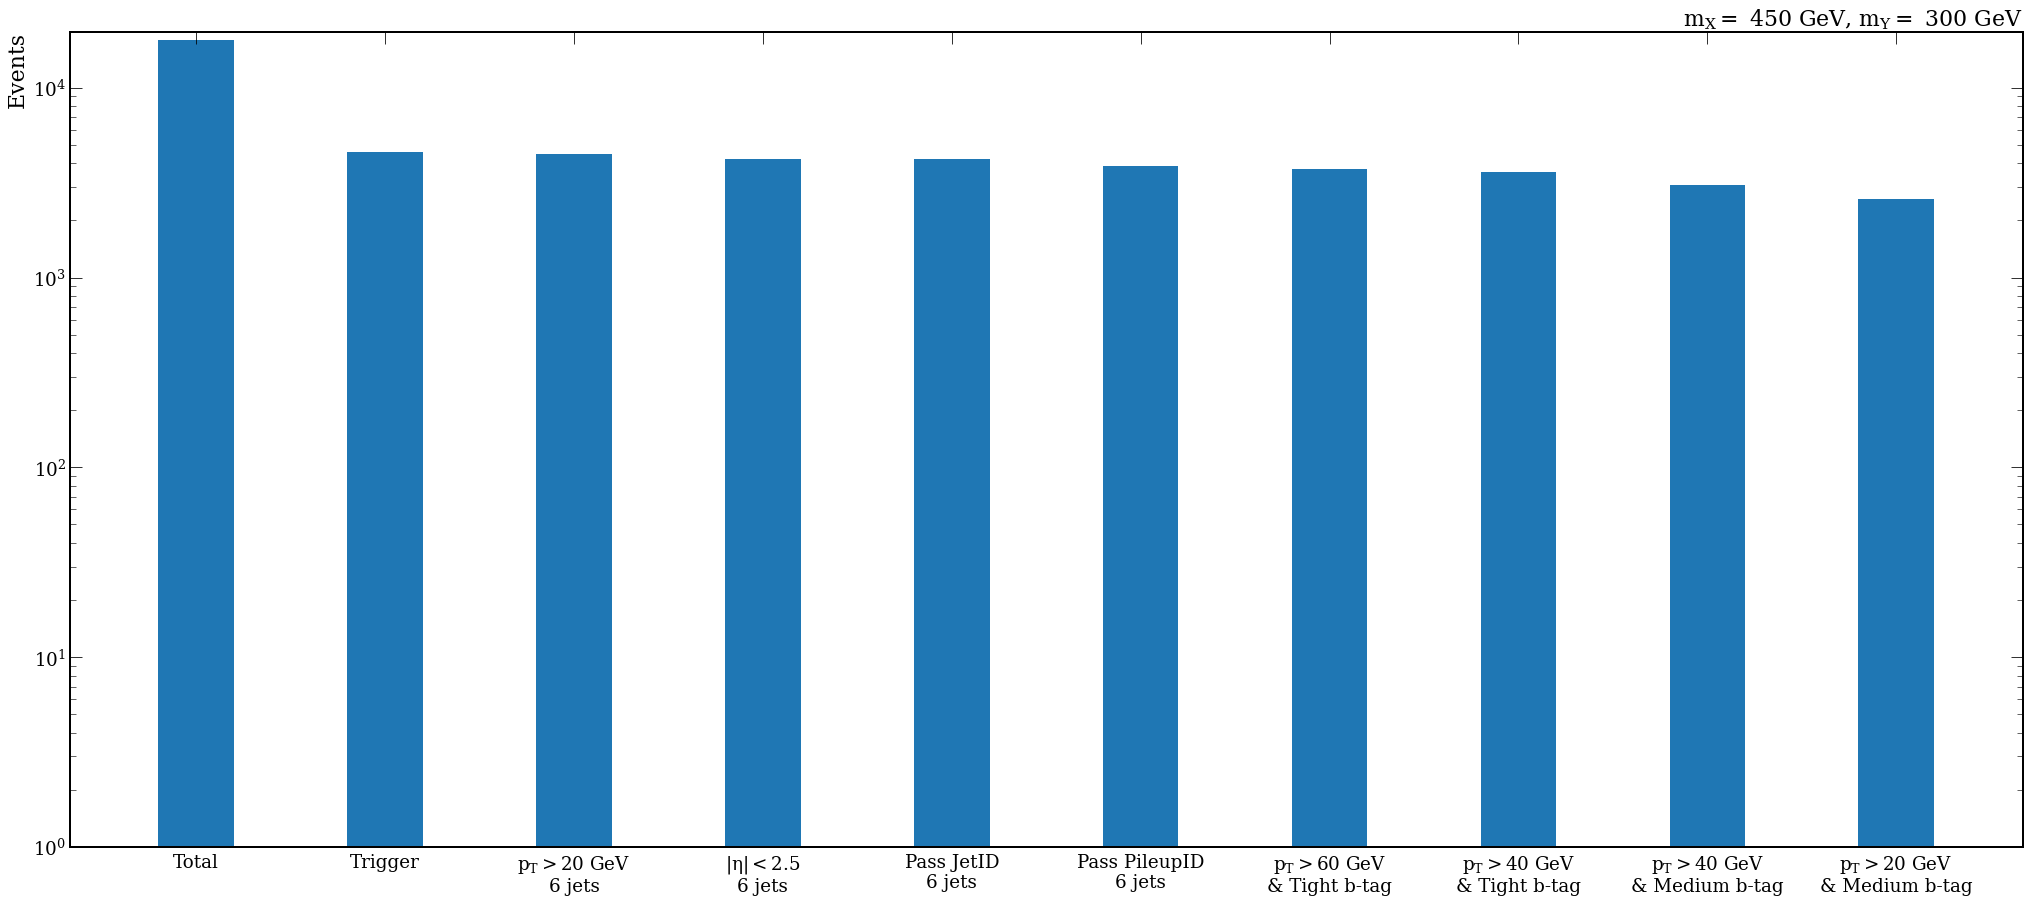

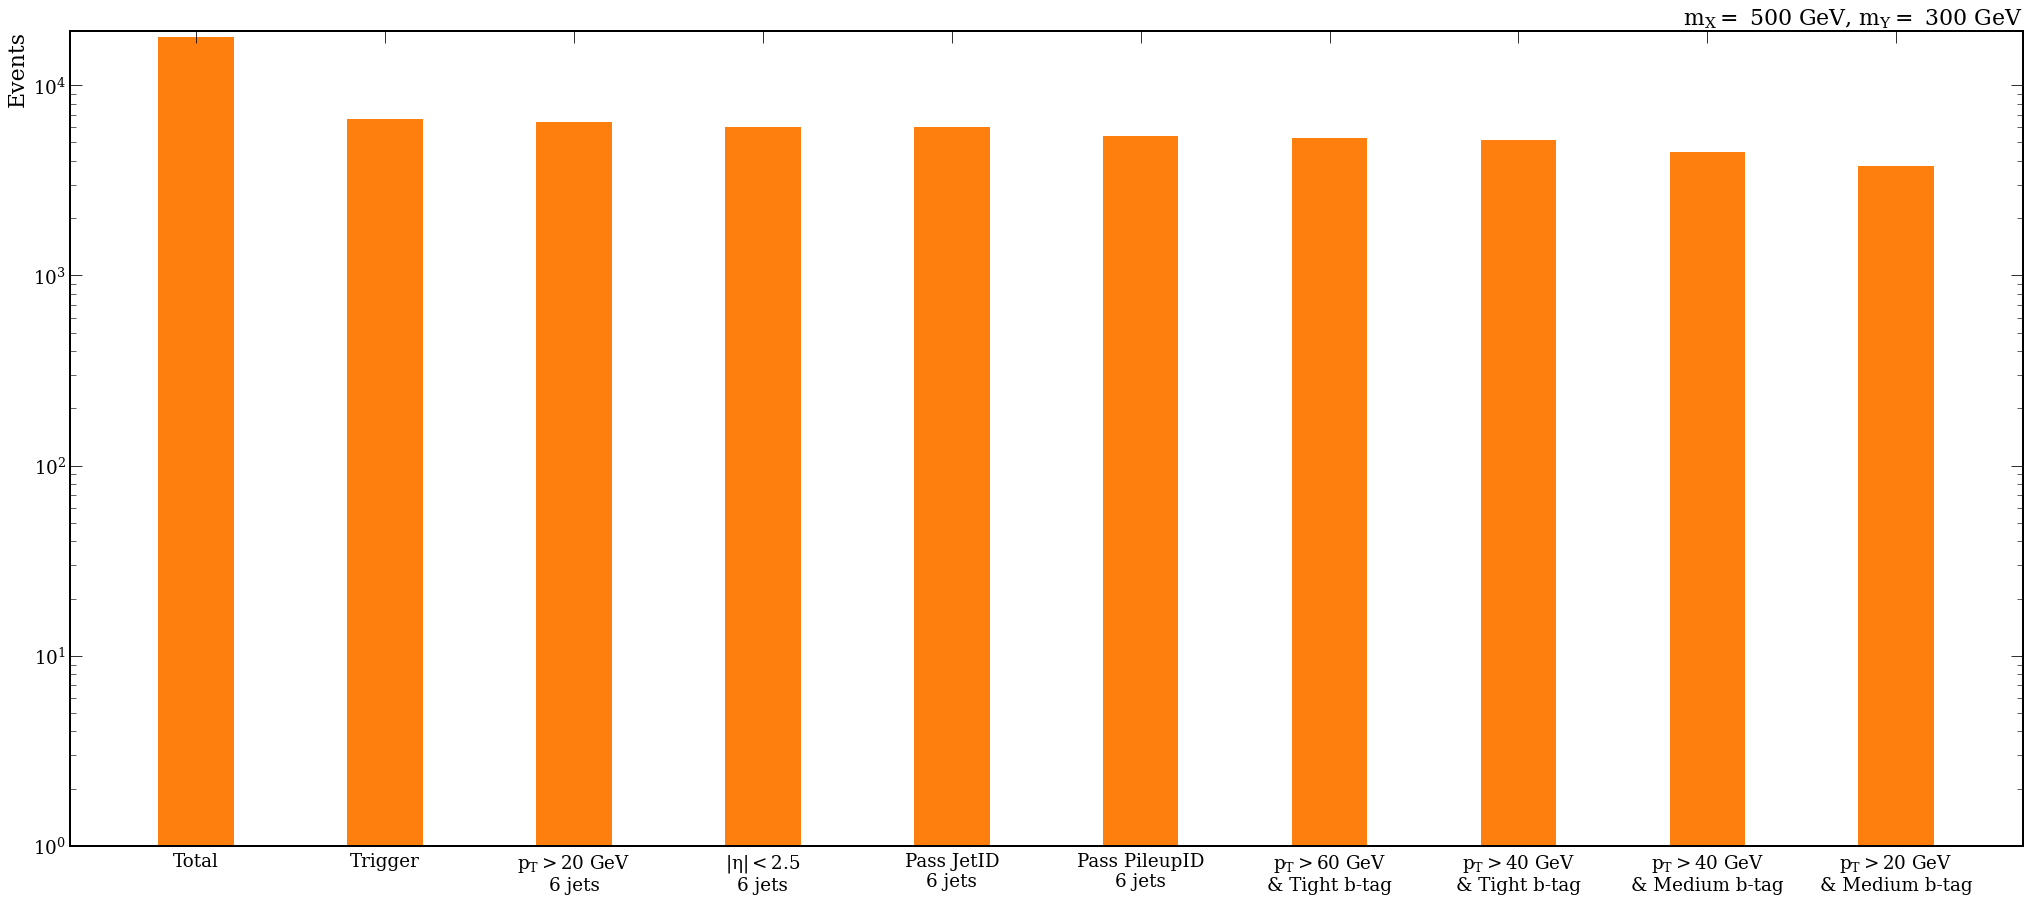

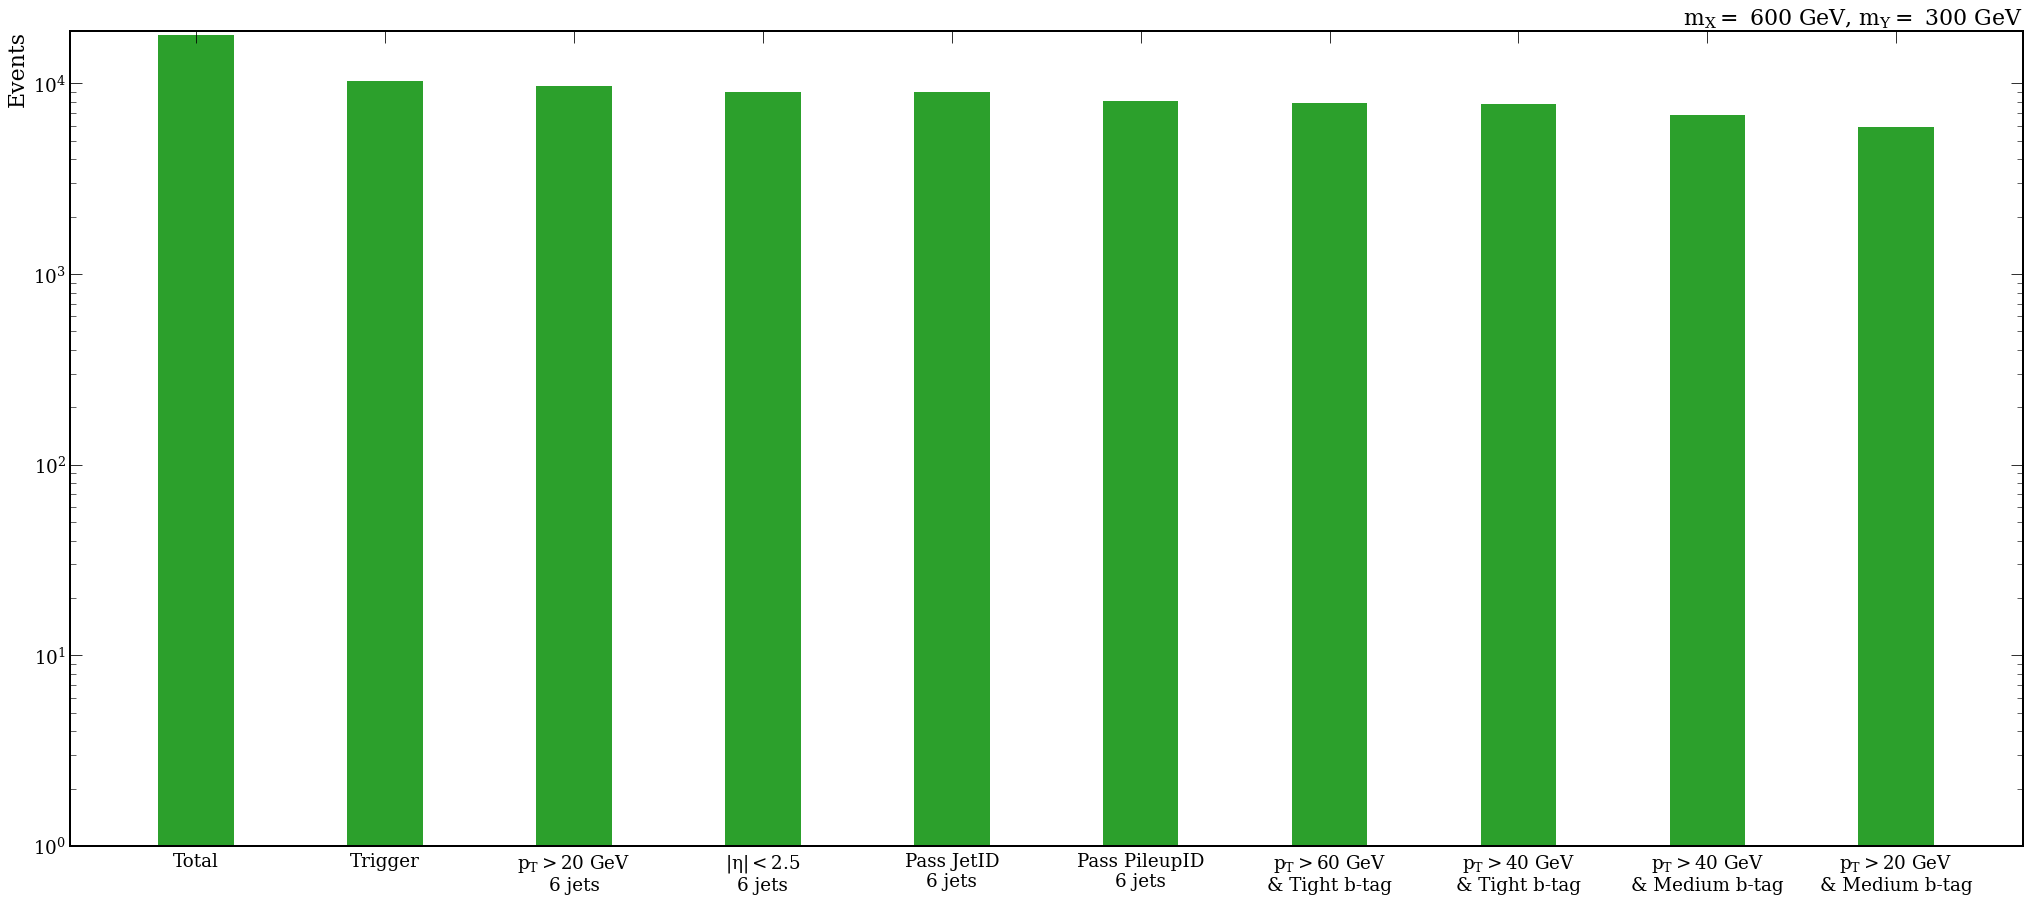

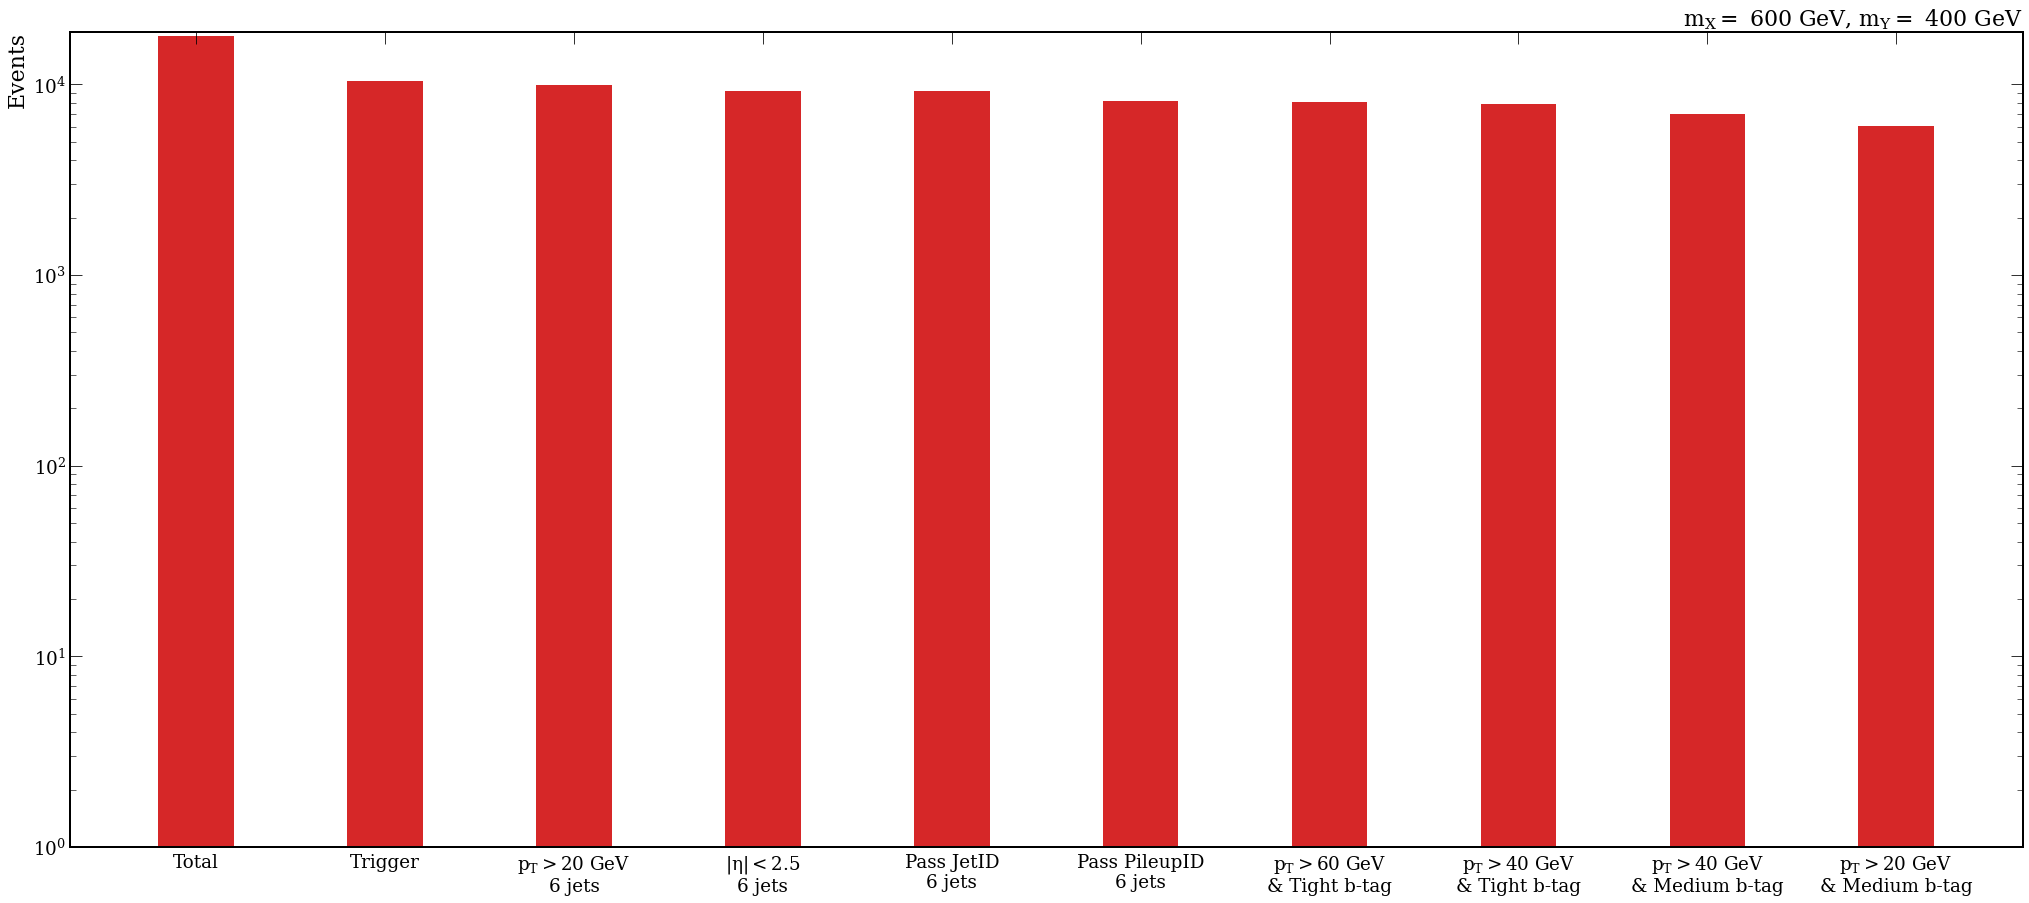

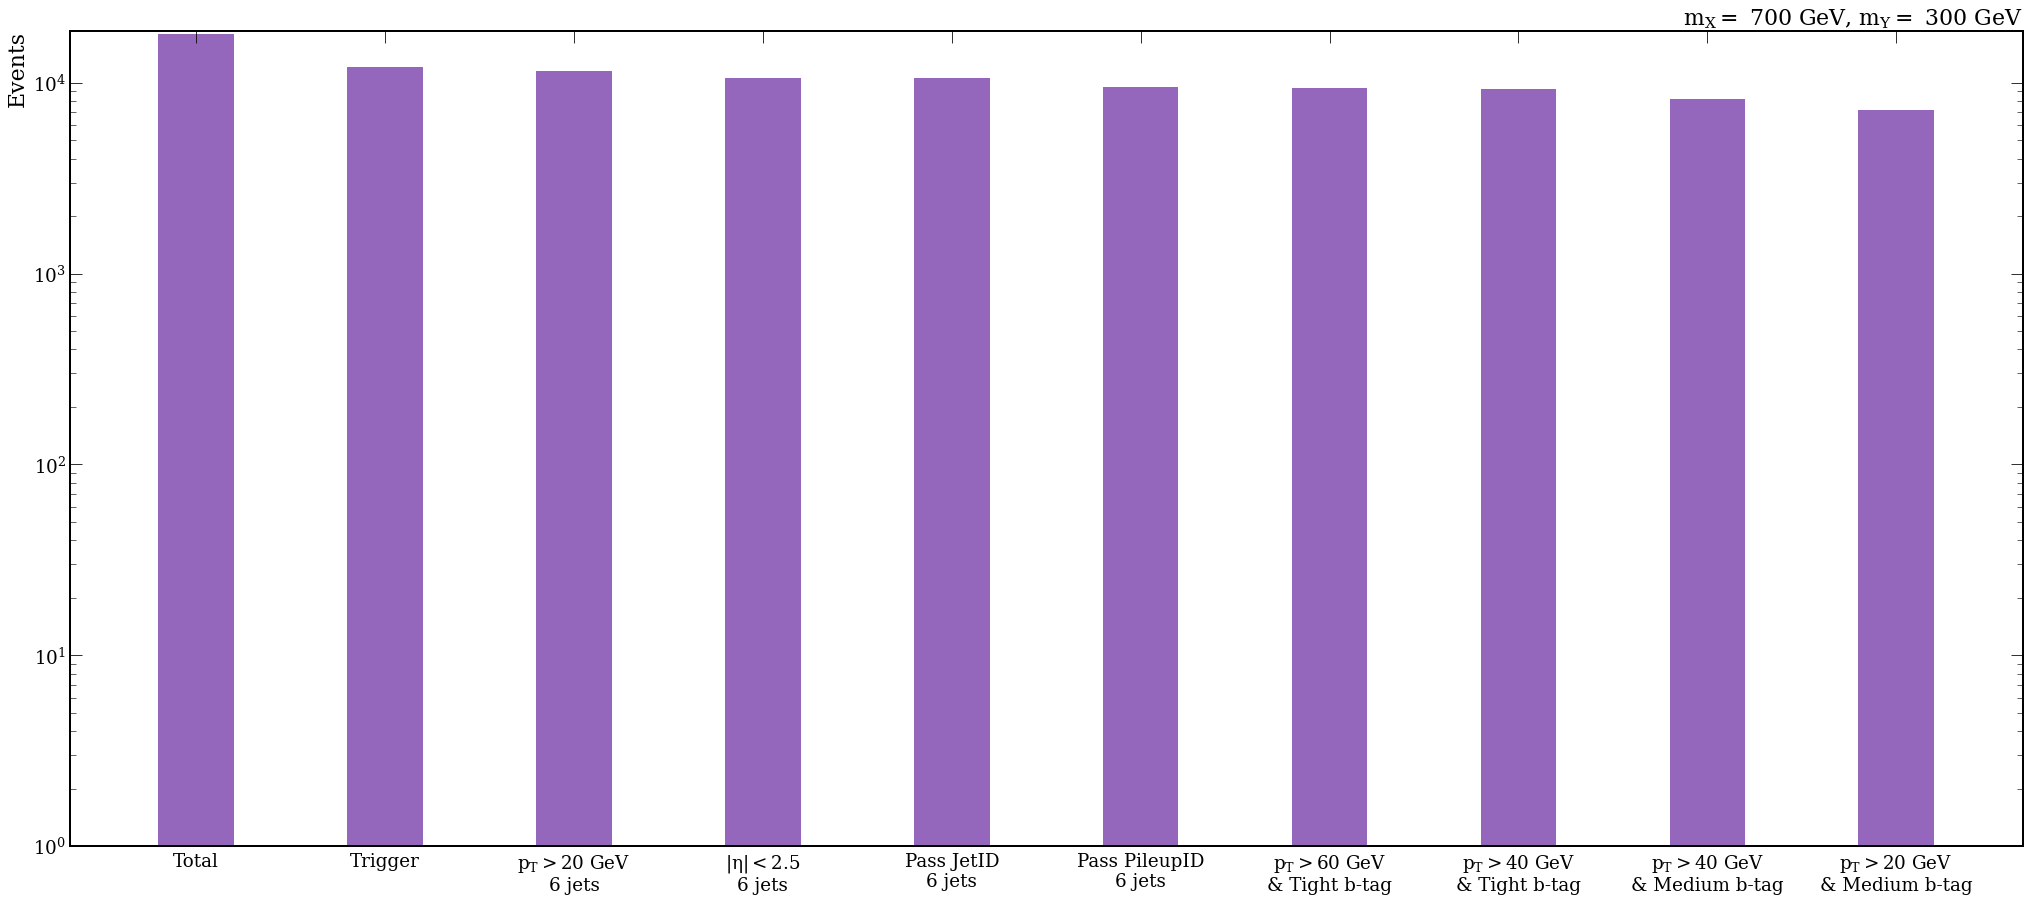

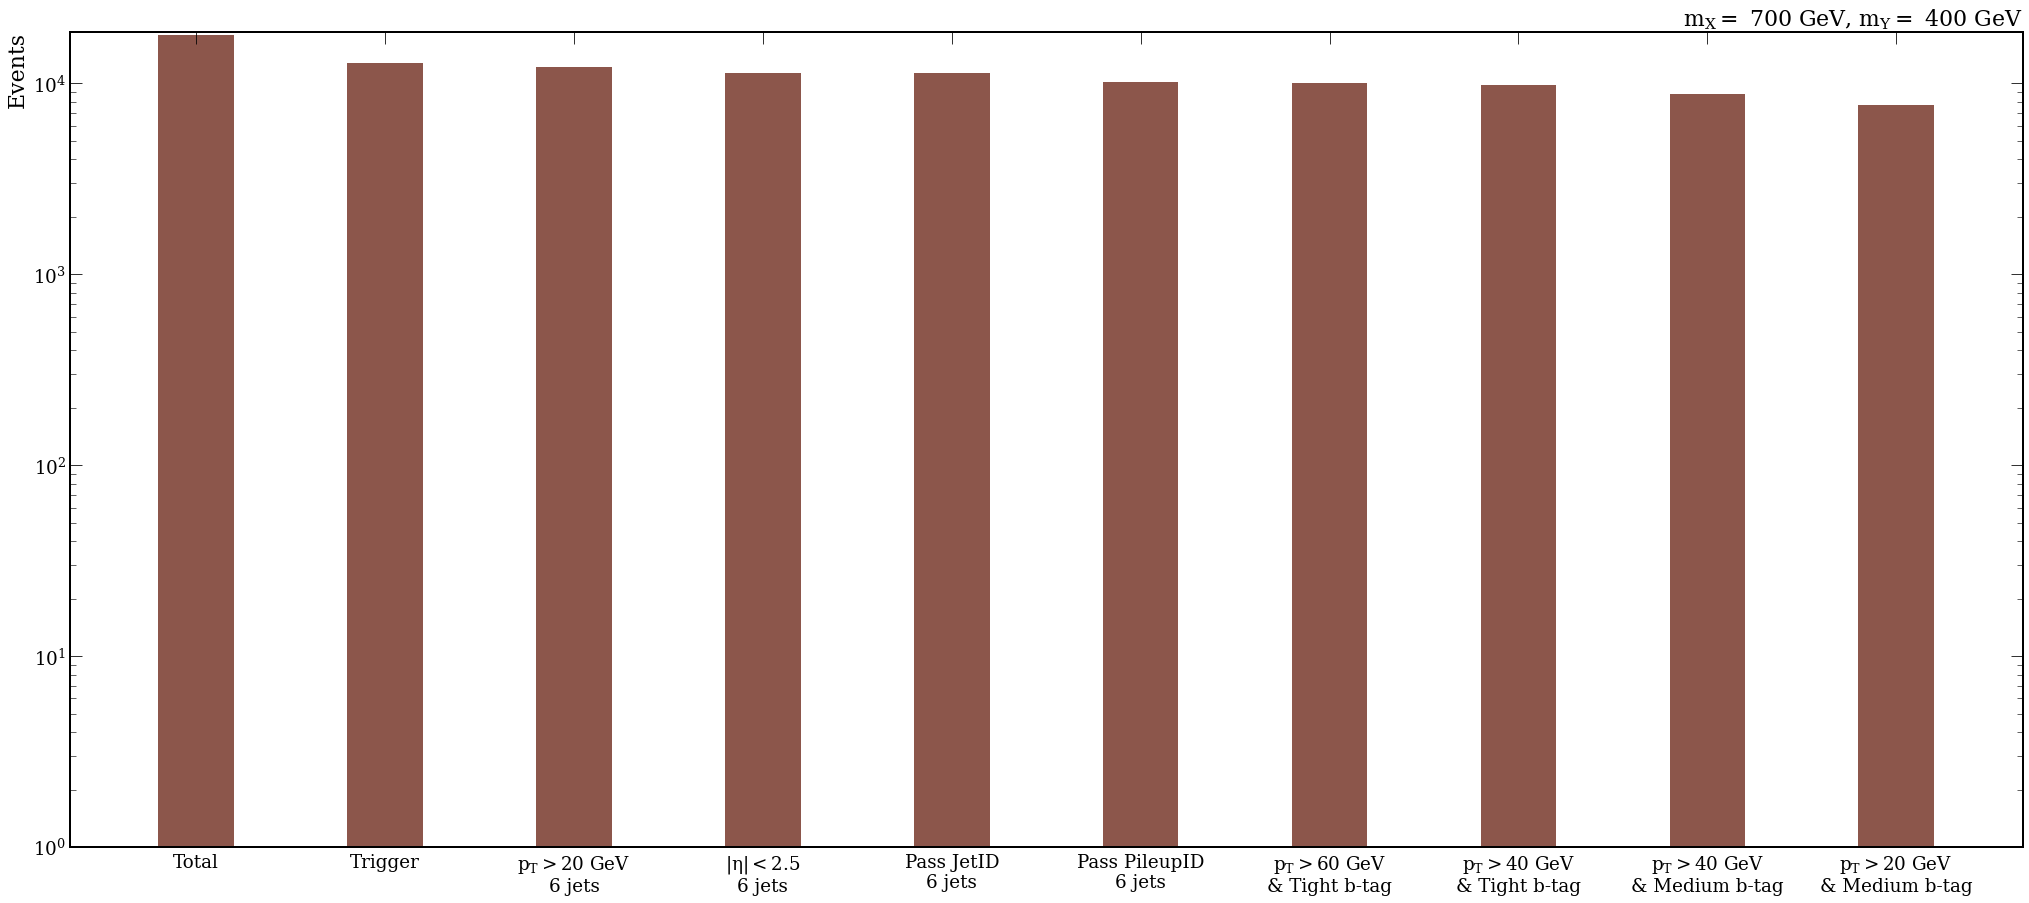

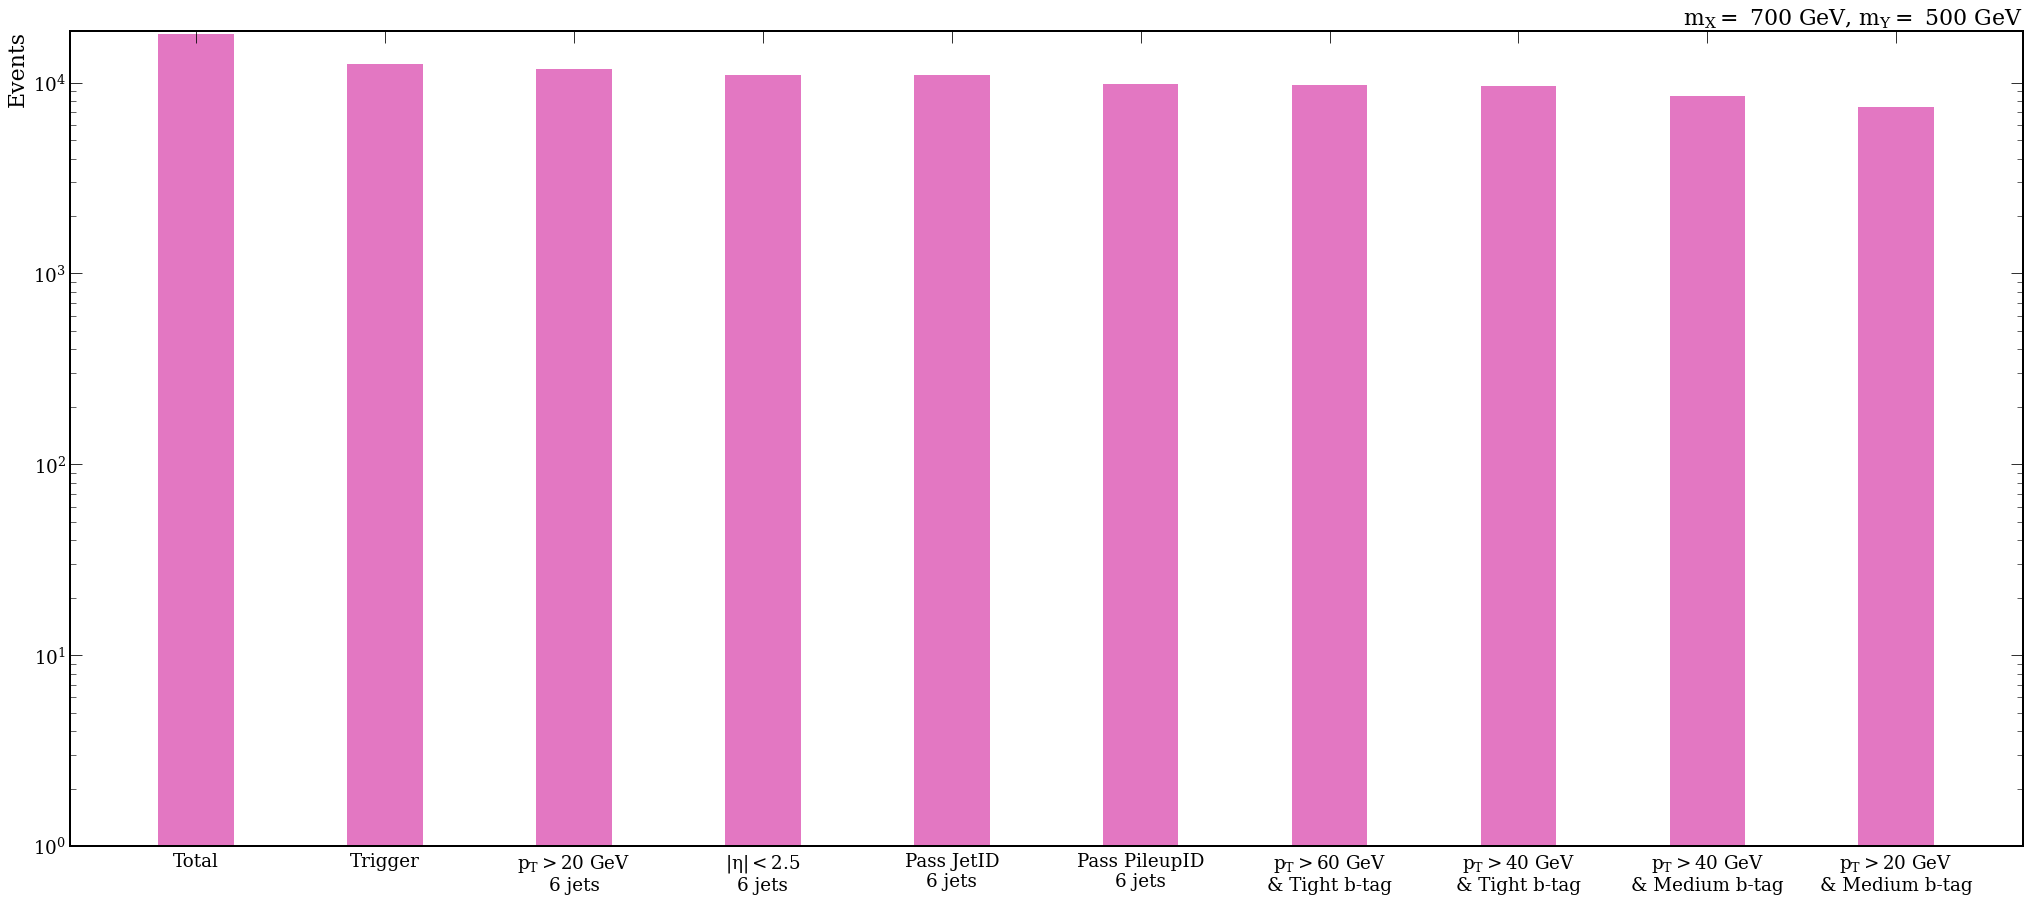

In [21]:
year = 2018
for i,(sample,cutflow) in enumerate(zip(NMSSM_List,cutflows)):
    fig, ax = plt.subplots(figsize=(35,15))
    mass_point = sample.split("/")[-2] # extract mass point for saving plots
    cf = cutflow
    bar = ax.bar(x=np.arange(0,ncuts), height=cf, width=0.4, align='center', log=True, color='C'+str(i))
    ax.set_title(makeTitle(sample), loc='right')
    ax.xaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.xaxis.set_tick_params(which='major', bottom=False, top=True)
    ax.set_xticks(np.arange(0,ncuts))
    ax.set_xticklabels(cf_labels[::-1], ha='center')
    ax.set_ylabel('Events')
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(1,ymax)
    fig.savefig(f'plots/{mass_point}_cutflow_bar.pdf')

# ymin, ymax = ax.get_ylim()
# ax.set_ylim(1, ymax*50)


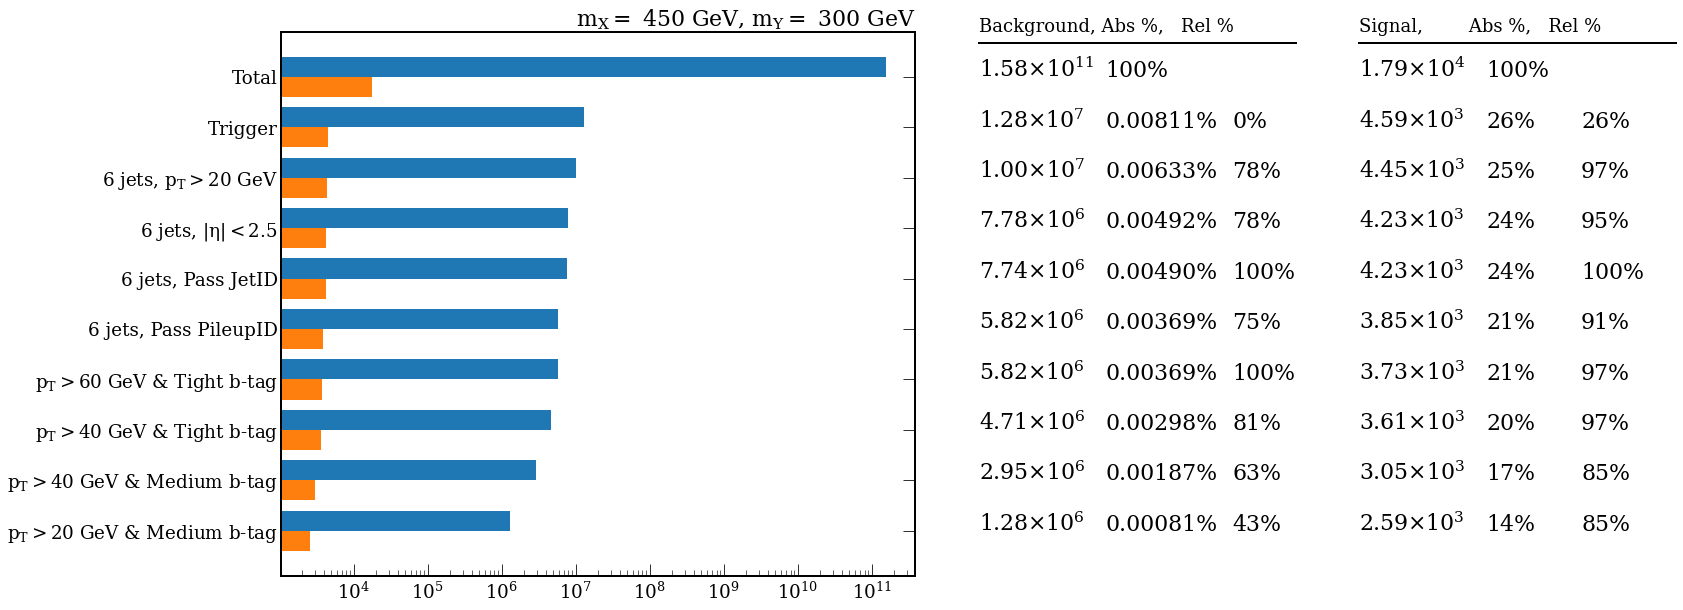

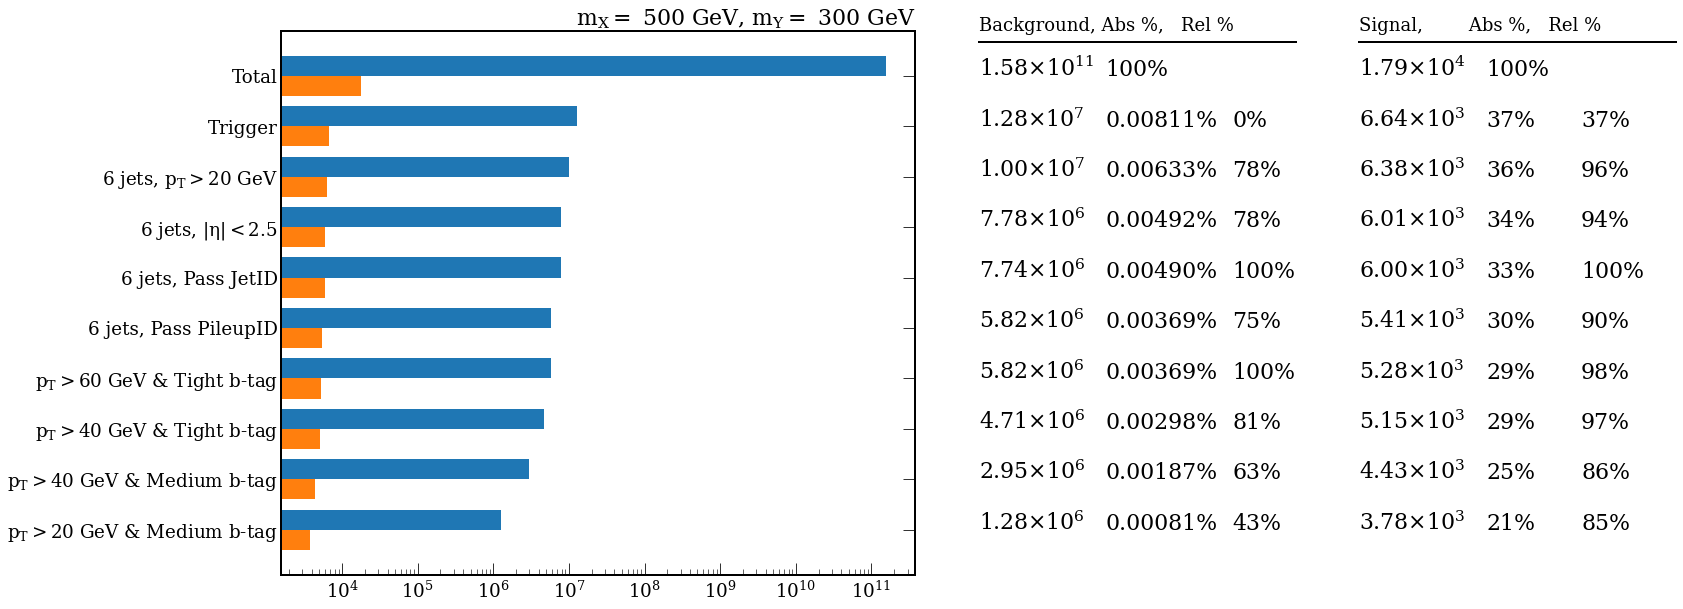

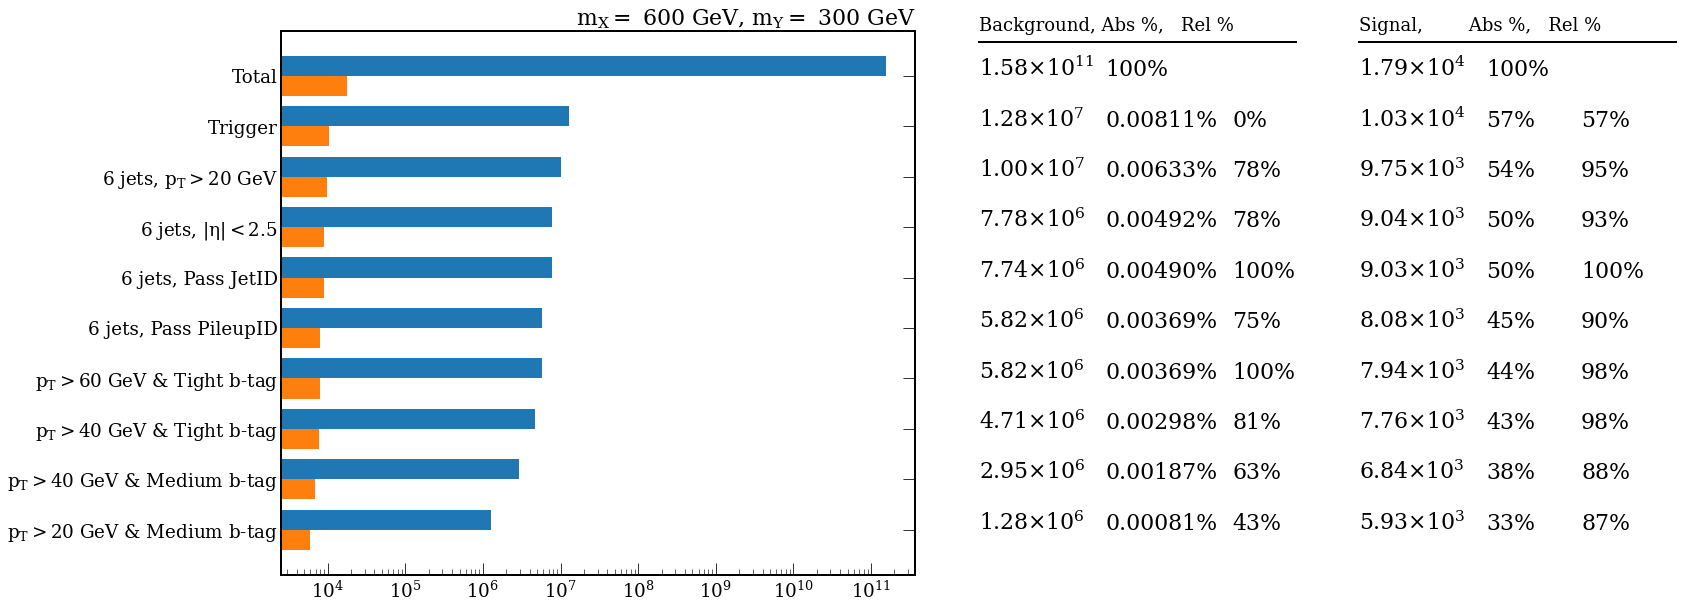

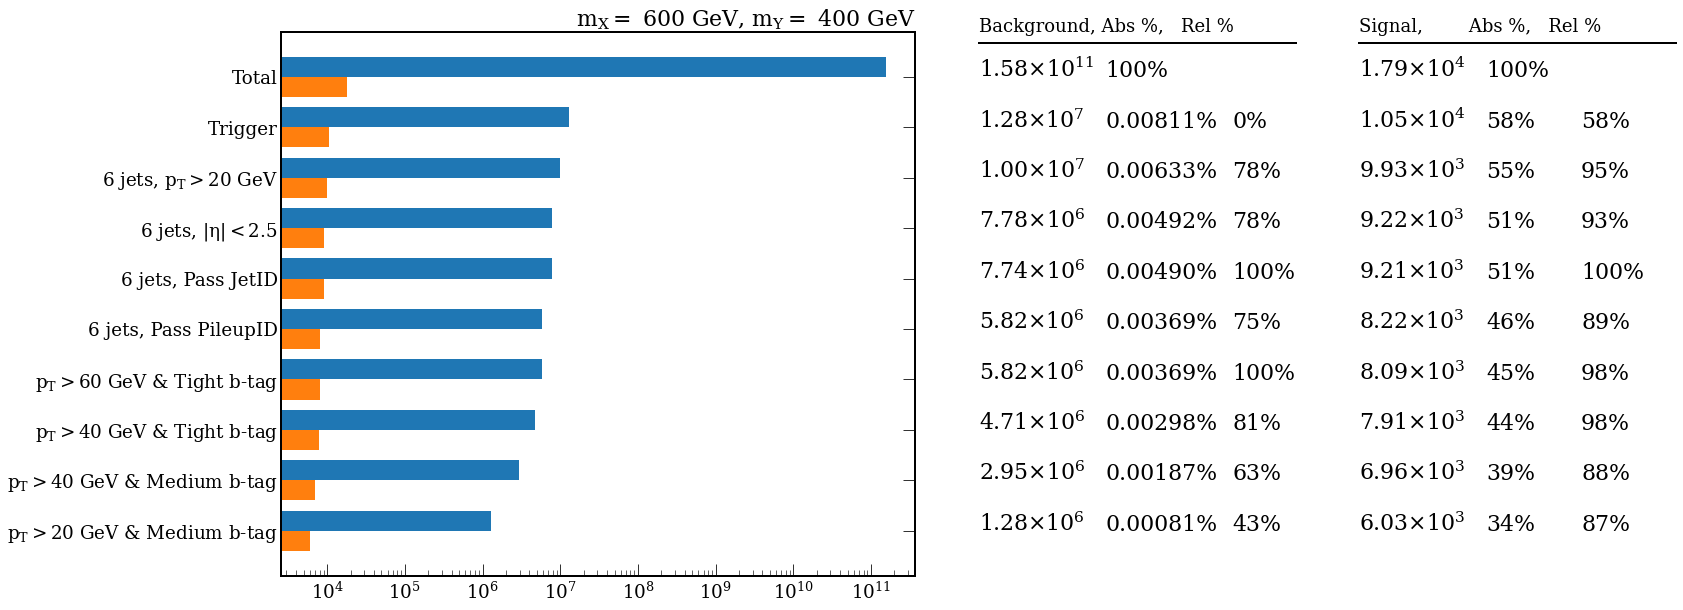

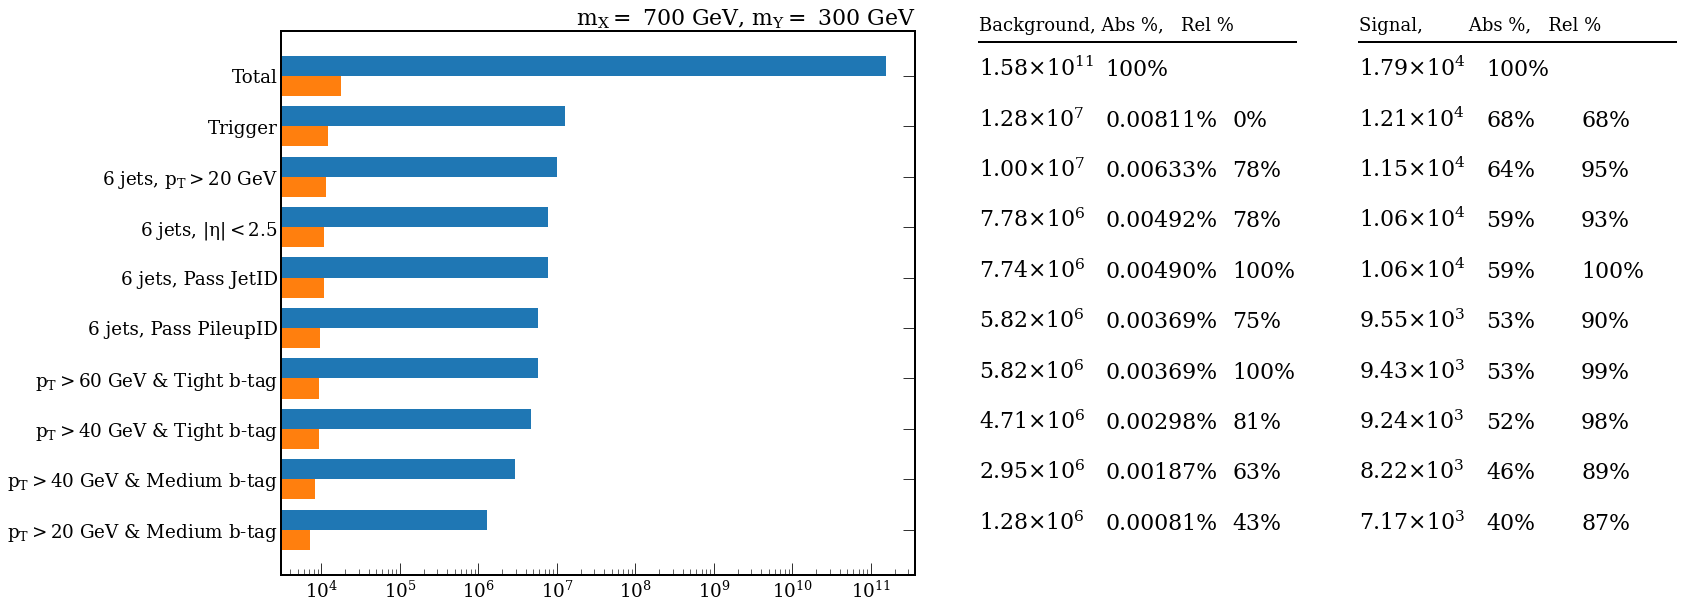

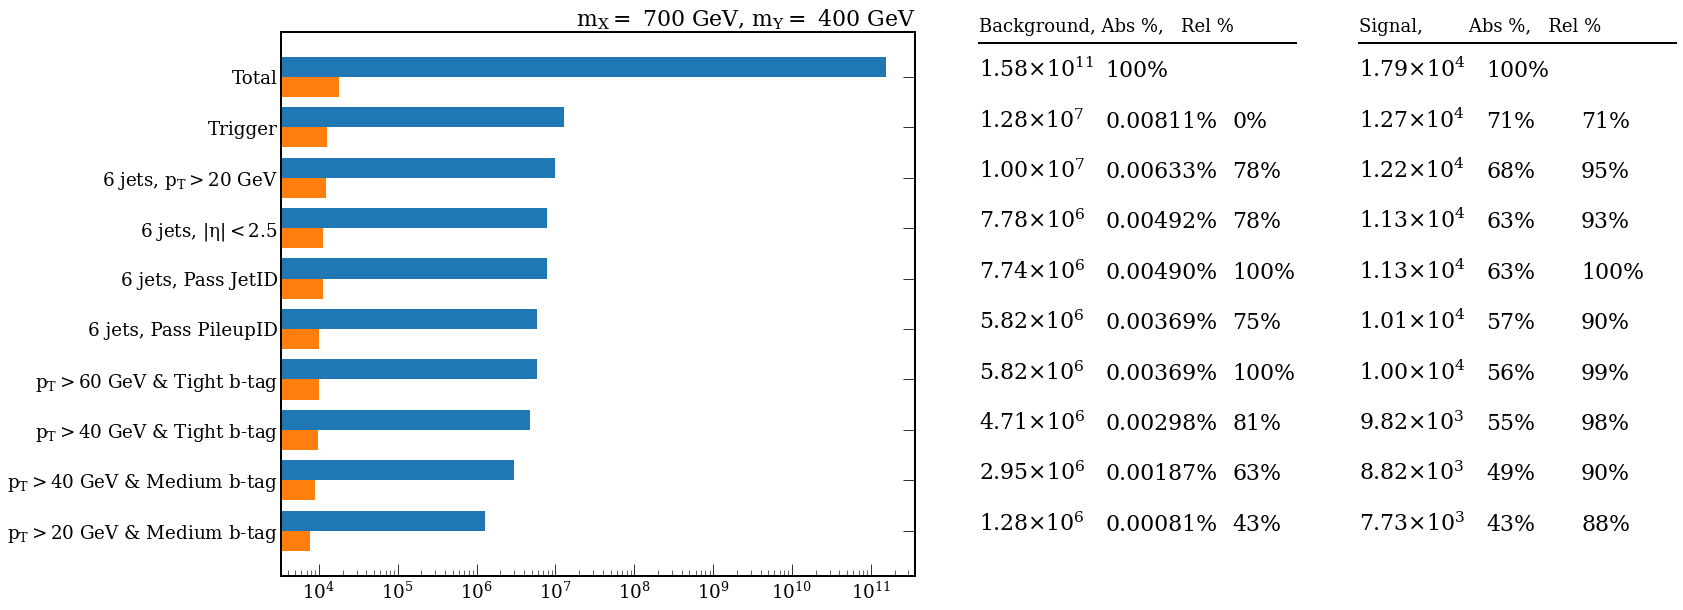

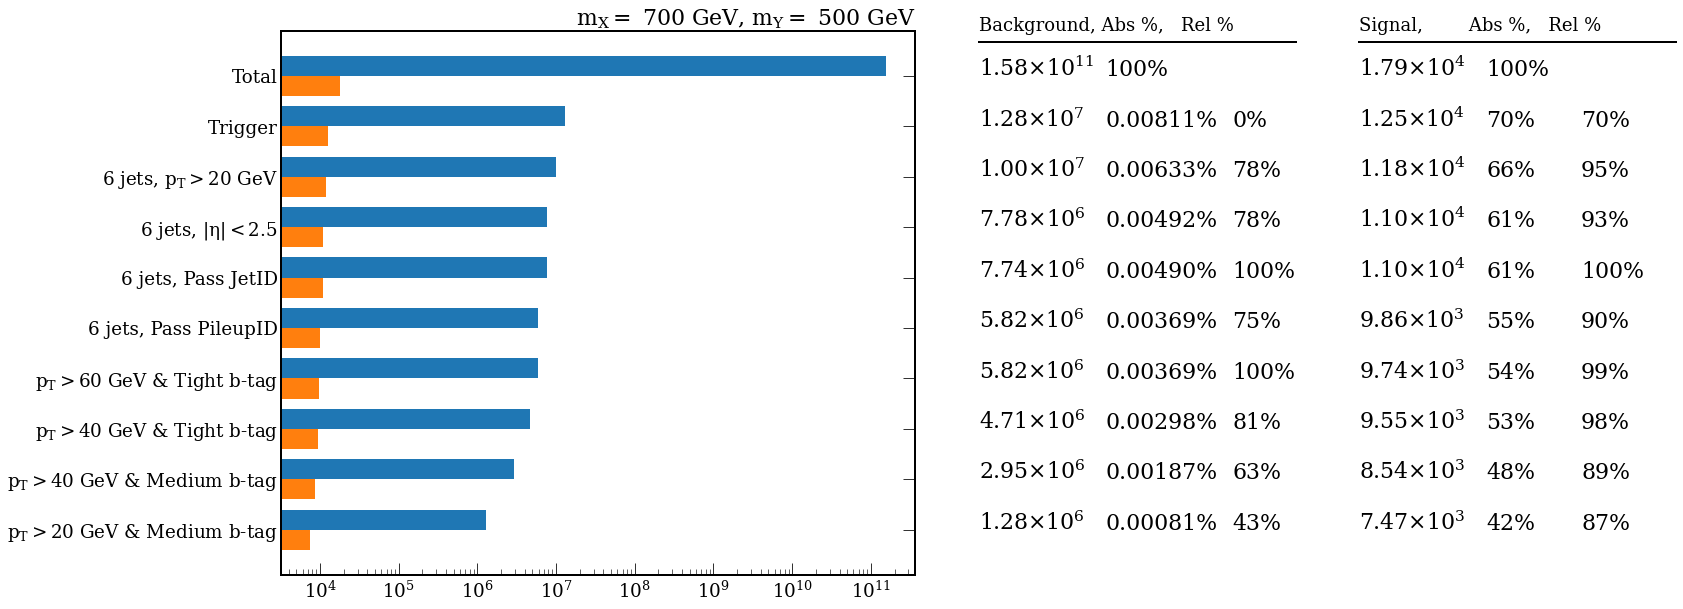

In [49]:
year = 2018
for sample,cutflow in zip(NMSSM_List, cutflows):
# for sample in [NMSSM_MX_700_MY_400]:
    mass_point = sample.split("/")[-2] # extract mass point for saving plots
    
    # create cutflow object
    cf = cutflow

    # make figure and axis objects
    fig, axs = plt.subplots(figsize=(25,10), nrows=1, ncols=2, gridspec_kw={'width_ratios':[1,1]}, sharey=True)

    # first axis will contain horizontal bar chart
    ax = axs[0]
    # bar = ax.barh(y=np.arange(ncuts+0.4,0.4,-1), width=bkgd_tree.cutflow[:ncuts], height=0.4, align='center', log=True)
    bar = ax.barh(y=np.arange(ncuts,0,-1), width=cf, height=0.4, align='center', log=True)
    ax.yaxis.set_tick_params(which='minor', bottom=False, top=False)
    ax.yaxis.set_tick_params(which='major', bottom=False, top=True)
    ax.xaxis.set_major_locator(ticker.LogLocator(numticks=10))
    ax.xaxis.set_major_formatter(ticker.LogFormatterSciNotation(labelOnlyBase=True))
    ax.xaxis.set_minor_locator(ticker.LogLocator(subs=np.arange(10), numticks=10))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.set_yticks(np.arange(1.2,ncuts+1.2))
    # ax.set_yticklabels(cf_labels[ncuts-1:])
    ax.set_yticklabels(cf_labels)
    ax.set_title(makeTitle(sample), loc='right')

    ax = axs[1]
    ax.axis('off')
    ax.text(-0.1,1,'Background, Abs %,   Rel %', transform=ax.transAxes, fontdict={'fontsize':18})
    # ax.text(-0.1,1,'Background, Abs %,   Rel %', transform=ax.transAxes, fontdict={'fontsize':18})
    ax.text(0.5,1,'Signal,        Abs %,   Rel %', transform=ax.transAxes, fontdict={'fontsize':18})
    ax.add_line(lines.Line2D([-0.1, 0.4], [0.98,0.98], transform=ax.transAxes, color='k', linewidth=2, clip_on=False))
    ax.add_line(lines.Line2D([0.5, 1], [0.98,0.98], transform=ax.transAxes, color='k', linewidth=2, clip_on=False))

    for i,(ypos, n_bkgd, n_sig) in enumerate(zip(np.arange(ncuts+0.2,0.2,-1), bkgd_tree.cutflow, cf)):
        if i == 0: 
            ax.text(-0.1, ypos, as_si(n_bkgd,2))
            ax.text(0.1, ypos, f"100%")
            ax.text(0.3, ypos, f"")
            ax.text(0.5, ypos, as_si(n_sig,2))
            ax.text(0.7, ypos, f"100%")
            ax.text(0.85, ypos, f"")
        else:
            ax.text(-0.1, ypos, as_si(n_bkgd,2))
            # ax.text(-0.1, ypos, f"{as_si(n_bkgd/bkgd_tree.cutflow[0], 2)}")
            ax.text(0.1, ypos, f"{n_bkgd/bkgd_tree.cutflow[0]*100:.5f}%")
            ax.text(0.3, ypos, f"{n_bkgd/bkgd_tree.cutflow[i-1]*100:.0f}%")
            # ax.text(0.5, ypos, f"{as_si(n_sig/signal_tree.cutflow[0], 2)}")
            ax.text(0.5, ypos, as_si(n_sig,2))
            ax.text(0.7, ypos, f"{n_sig/cf[0]*100:.0f}%")
            ax.text(0.85, ypos, f"{n_sig/cf[i-1]*100:.0f}%")

        fig.savefig(f'plots/{mass_point}_cutflow_plot_table.pdf')

290744.63037109375


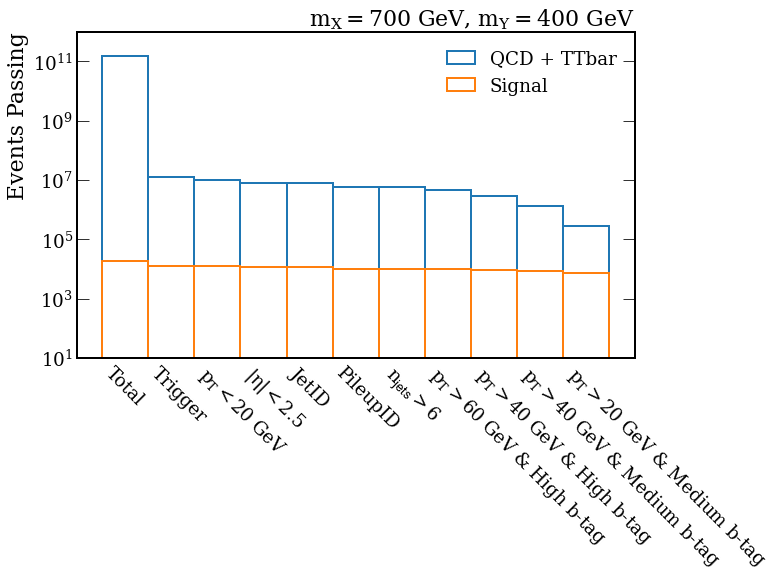

In [162]:
fig, ax, n, b = Hist(x=np.arange(0.5,11.5), weights=bkgd_tree.cutflow, bins=np.arange(12), linewidth=2, label='QCD + TTbar')
for bin,val in zip(b[1:-1],n[:-1]):
    ax.plot([bin,bin],[0,val], c='C0', linewidth=2)
print(n[-1])
fig, ax, n, b = Hist(x=np.arange(0.5,11.5), weights=signal_tree.cutflow, bins=np.arange(12), linewidth=2, label='Signal', fig=fig, ax=ax)
for bin,val in zip(b[1:-1],n[:-1]):
    ax.plot([bin,bin],[0,val], c='C1', linewidth=2)
ax.set_ylim(10,1e12)
ax.set_yscale('log')
ax.set_ylabel('Events Passing')
ax.set_xticks(np.arange(0,11))
ax.set_xticklabels(labels=['Total','Trigger',r'$p_T<20$ GeV', r'$|\eta|<2.5$', 'JetID', 'PileupID', r'$n_\mathrm{jets} > 6$', r'$p_T>60$ GeV & High b-tag', r'$p_T>40$ GeV & High b-tag', r'$p_T>40$ GeV & Medium b-tag', r'$p_T>20$ GeV & Medium b-tag'], rotation=315, ha='left', fontfamily='serif')
ax.set_title(r'$m_X = 700$ GeV, $m_Y = 400$ GeV', loc='right')

fig.savefig('plots/event_preselection.pdf', bbox_inches='tight')